# **Báo cáo đồ án môn "Khoa học dữ liệu ứng dụng"**

Nhóm 3:
1. 1712401 - Hồ Trường Giang - TruongGiangBT
2. 1712575 - Hoàng Xuân Long - dralong10
3. 18120249 - Hồ Minh Trí - Crys-Zz0o0
4. 18120374 - Nguyễn Minh Hiếu - templarassVN

Link thùng chứa Github của nhóm: [Link](https://github.com/templarassVN/Team-3_KHDLUD_K18)

## Mô tả bài toán

- Là cuộc thi dự đoán đội thắng và đội thua trong giải đấu bóng rổ nam NCAA năm 2021 (2020-2021) (2021 NCAA Division I Men's Basketball Tournament). [Link](https://www.kaggle.com/c/ncaam-march-mania-2021)
- Cuộc thi chia làm 2 giai đoạn:
  - Giai đoạn 1: Ban tổ chức sẽ cung cấp dữ liệu các trận đấu của các đội ở các mùa giải trước đến mùa giải 2019. Mục đích là để người tham gia có dữ liệu để xây dựng và thử nghiệm các mô hình.
  - Giai đoạn 2: Ban tổ chức sẽ cung cấp thêm dữ liệu về các đội được tham gia giải đấu năm 2021. Người tham gia sẽ tiến hành dự đoán và submit kết quả.
- Tổng quan về giải đấu:
  - Giải đấu gồm 68 đội tham gia chia đều ở 4 khu vực.
  - 8 đội First-Four sẽ thi đấu 4 trận đấu đầu tiên để tranh quyền đi tiếp => Còn lại 64 đội (Mỗi khu cực có 16 đội).
  - 16 đội trong mỗi khu vực sẽ đấu loại trực tiếp theo quy định của giải đấu và chọn ra đội thắng cuộc đại diện cho khu vực thi đấu ở vòng Final Four. Tại vòng Final Four, 4 đội đại diện cho 4 khu vực tiếp tục loại trực tiếp nhau và chọn ra người thắng chung cuộc. 
  - Tổng cộng sẽ có 67 trận đấu (gồm 4 trận First-Four, 15 trận đấu loại khu vực * 4 khu vực, 3 trận Final Four).
- Mô hình bài toán: Dựa vào các thông số thi đấu và thành tích. Ta sẽ thực hiện huấn luyện mô hình với input đầu vào là ID 2 đội (TeamIdA,TeamIdB) và các thuộc tính được rút trích của mỗi đội. Nhãn của mỗi cặp đấu có giá trị là 0 hoặc 1 (0 - đội A thua; 1 - đội A thắng)
- Input bài toán: Đầu vào bài toán là danh sách 68 đội tham gia giải đấu, về mặt lý thuyết ta sẽ có 68*67/2 = 2278 cặp đấu khác nhau. Ta sẽ dự đoán kết quả của 2278 cặp đấu.
- Output: Xác suất đội A thắng đội B.
- Cấu trúc file Submission gồm:
  - Id: [Mùa giải]_ [TeamIdA]_[TeamIdB]. Ex: 2021_1101_1102
  - Pred: Xác suất đội A thắng đội B
- Đánh giá kết quả: Kết quả dự đoán được đánh giá bằng hàm Log Loss.
$$\textrm{LogLoss} = - \frac{1}{n} \sum_{i=1}^n \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]$$

## Giải quyết bài toán

- Nhóm đã tìm hiểu và cài đặt lại [giải pháp của tác giả kazukim](https://www.kaggle.com/c/ncaam-march-mania-2021/discussion/230946), đứng thứ 4 private leaderboard với score là 0.56346.
- Nhóm chọn giải này vì đây là giải pháp giành thứ hạng cao trong cuộc thi, tác giả có đề ra những đặc trưng hiệu quả trong việc dự đoán kết quả.
- Về cơ bản, nhóm đã tìm hiểu và code lại dựa trên mô tả và code mà tác giả cung cấp. Tuy nhiên, hầu như tác giả không giải thích rõ cho các đặc trưng (quan trọng với mô hình) nên nhóm đã tìm hiểu, nhận xét và chỉnh sửa lại theo quan điểm của mình.

### I. Nạp dữ liệu và thư viện cần thiết

Những tập dữ liệu cần thiết sẽ được tự động tải về và giải nén ở đây.

In [ ]:
!gdown --id 1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
!gdown --id 1Bwe5QinxXItR6g5ODd8AGFYeHQR1xNJ-
!unzip ncaam-march-mania-2021.zip

Downloading...
From: https://drive.google.com/uc?id=1c6Iiy39qeiI1sH1N5MKrBe1C9e8E16Hl
To: D:\Subject\DS&Application\Team-3_KHDLUD_K18\ncaam-march-mania-2021.zip

  0%|          | 0.00/44.7M [00:00<?, ?B/s]
  1%|1         | 524k/44.7M [00:00<00:21, 2.08MB/s]
  4%|3         | 1.57M/44.7M [00:00<00:09, 4.34MB/s]
  6%|5         | 2.62M/44.7M [00:00<00:09, 4.29MB/s]
  7%|7         | 3.15M/44.7M [00:00<00:09, 4.20MB/s]
 12%|#1        | 5.24M/44.7M [00:00<00:05, 7.70MB/s]
 14%|#4        | 6.29M/44.7M [00:01<00:04, 8.18MB/s]
 16%|#6        | 7.34M/44.7M [00:01<00:05, 6.96MB/s]
 19%|#8        | 8.39M/44.7M [00:01<00:05, 6.68MB/s]
 22%|##2       | 9.96M/44.7M [00:01<00:04, 8.18MB/s]
 25%|##4       | 11.0M/44.7M [00:01<00:04, 7.97MB/s]
 27%|##6       | 12.1M/44.7M [00:01<00:04, 8.09MB/s]
 29%|##9       | 13.1M/44.7M [00:01<00:04, 7.40MB/s]
 33%|###2      | 14.7M/44.7M [00:02<00:04, 7.32MB/s]
 35%|###5      | 15.7M/44.7M [00:02<00:03, 7.58MB/s]
 38%|###7      | 16.8M/44.7M [00:02<00:03, 8.04MB/s]


In [ ]:
# Load các thư viện cần thiết
!pip install lightgbm
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

### II. Đọc dữ liệu

- Giải pháp hiện tại nhóm đang làm sử dụng dữ liệu từ 4 file csv: 
  - MMasseyOrdinals.csv
    - Mô tả: Là danh sách thứ hạng của các đội kể từ mùa giải 2003 dựa trên các hệ thống xếp hạng.
    - Thuộc tính:
      - Season: năm của mùa giải.
      - RatingDayNum: ngày trong mùa giải đó (Ngày bắt đầu mùa giải => RatingDayNum = 0).
      - SystemName: tên hệ thống xếp hạng, gồm 3 chữ cái in hoa.
      - TeamID: mã số của đội, gồm số có 4 chữ số, bắt đầu từ 1101.
      - OrdinalRank: thứ hạng.
  - MNCAATourneySeeds.csv
    - Mô tả: Xác định hạt giống của các đội tham gia giải đấu ở các mùa giải.
    - Thuộc tính:
      - Season, Team ID.
      - Seed: chuỗi gồm 3 hoặc 4 kí tự, kí tự đầu tiên ứng với mã khu vực của đội, 2 kí tự số tiếp theo là hạng hạt giống của đội, kí tự thứ 4 (nếu có) để phân biệt đội sẽ tham gia First-Four (Ví dụ: W11a - đội này xếp hạng hạt giống 11 trong khu vực W về sẽ thi đấu First-Four).
  - MRegularSeasonDetailedResults.csv
    - Mô tả: Cung cấp kết quả chi tiết của các trận đấu trước giải đấu (DayNum < 132), bao gồm điểm số và thông số trận đấu của các cặp đấu.
    - Thuộc tính:
      - Season
      - WTeamID, LTeamID: ID của đội thắng/đội thua.
      - DayNum: ngày thi đấu.
      - WScore, LScore: số điểm ghi được của đội thắng/ đội thua.
      - WLoc: đội được chơi trên sân: H - sân nhà, A - sân khách, N - sân trung lập.
      - NumOT: thời gian bù giờ.
      - WFGM, WFGA, WFGM3, WFGA3, WFTM, WFTA, WOR, WDR, WAst, WTO, WStl, WBlk, WPF: các thông số trận đấu của đội thắng. Tương tự, đội thua có kí tự 'L' ở đầu. 
  - MNCAATourneyCompactResults.csv
    - Mô tả: Cung cấp kết quả rút gọn của các trận đấu trong mùa giải, gồm điểm số của các cặp đấu.
    - Thuộc tính:
      - Season, WTeamID, LTeamID, DayNum, WScore, LScore, WLoc, NumOT

In [ ]:
datasets_path = './MDataFiles_Stage2/'
os.listdir('./MDataFiles_Stage2/')

['Cities.csv',
 'Conferences.csv',
 'MConferenceTourneyGames.csv',
 'MGameCities.csv',
 'MMasseyOrdinals.csv',
 'MNCAATourneyCompactResults.csv',
 'MNCAATourneyDetailedResults.csv',
 'MNCAATourneySeedRoundSlots.csv',
 'MNCAATourneySeeds.csv',
 'MNCAATourneySlots.csv',
 'MRegularSeasonCompactResults.csv',
 'MRegularSeasonDetailedResults.csv',
 'MSampleSubmissionStage2.csv',
 'MSeasons.csv',
 'MSecondaryTourneyCompactResults.csv',
 'MSecondaryTourneyTeams.csv',
 'MTeamCoaches.csv',
 'MTeamConferences.csv',
 'MTeams.csv',
 'MTeamSpellings.csv']

In [ ]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RatingDayNum':'DayNum'})
seeds = pd.read_csv(datasets_path + 'MNCAATourneySeeds.csv')
regular_results = pd.read_csv(datasets_path + 'MRegularSeasonDetailedResults.csv')
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')

### III. Prerocessing, Feature Extraction

#### 1. Tính trung bình tất cả hệ thống Rank, chuyển đồi sang Rating
- Dựa vào bảng MMasseyOrdinals, tính thứ hạng trung bình ở các hệ thống Ranking của các đội. Tạo ra thêm thuộc tính Rating để đánh giá các đội dựa vào thứ hạng của họ
* **INPUT**: Nội dung MMasseyOrdinals.csv có các cột: **Season; RankingDayNum;	SystemName;	TeamID;	OrdinalRank**
* **OUTPUT**: Chỉ lấy các cột **Season;	TeamID;	OrdinalRank;	Rating** với
    * Các sample là dùng GroupBy().last() có đặc điểm là RankingDayNum >= 133
    * OrdinalRank là lấy mean (dùng groupby SystemName và ID) 
    * Rating = 100 - 4 x log(OrdinalRank) 
    
    
- Note: 
    - Ở đây, thực ra tác giả đã sử dụng Rating = 100 - 4* log(ordinalRank) - Ordinalrank/22.
    - Tuy nhiên, theo như quá trình thử training và đánh giá thì nhóm không giải thích được chính xác số 22 được rút ra như thế nào. Nhóm giả thiết rằng đây chỉ là một bước sẽ kéo dãn range của Rating theo thông số OrdinalRank và cũng không giúp được nhiều cho việc training nên đã rút gọn công thức.

In [ ]:
ordinals = pd.read_csv(datasets_path + 'MMasseyOrdinals.csv').rename(columns={'RatingDayNum':'DayNum'})
ordinals

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4339985,2021,133,WOB,1467,233
4339986,2021,133,WOB,1468,176
4339987,2021,133,WOB,1469,290
4339988,2021,133,WOB,1470,256


In [ ]:
ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()

,SystemName,Season,TeamID,RankingDayNum,OrdinalRank
0,7OT,2012,1102,133,146
1,7OT,2012,1103,133,80
2,7OT,2012,1104,133,35
3,7OT,2012,1105,133,338
4,7OT,2012,1106,133,300
...,...,...,...,...,...
349598,ZAM,2019,1462,133,70
349599,ZAM,2019,1463,133,87
349600,ZAM,2019,1464,133,242
349601,ZAM,2019,1465,133,198


In [ ]:
#Lấy thứ hạn cuối cùng (thường DayNum=133) theo nhóm
ordinals = ordinals.groupby(['SystemName','Season','TeamID']).last().reset_index()
# Tạo bảng gồm Season, TeamID, OrdinalRank; với OrdinalRank là thứ hạn trung bình trên các SystemName
ordinals = ordinals.groupby(['Season','TeamID'])['OrdinalRank'].apply(list).apply(np.mean).reset_index()
# Thêm thuộc tính Rating
ordinals['Rating'] = 100 - 4*np.log(ordinals['OrdinalRank'])
ordinals

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,79.850662
1,2003,1103,168.705882,79.487373
2,2003,1104,36.638889,85.595559
3,2003,1105,308.735294,77.070063
4,2003,1106,260.911765,77.743271
...,...,...,...,...
6539,2021,1467,240.490566,78.069277
6540,2021,1468,180.288462,79.221767
6541,2021,1469,314.666667,76.993944
6542,2021,1470,252.823529,77.869233


Text(0.5, 1.0, 'Rating')

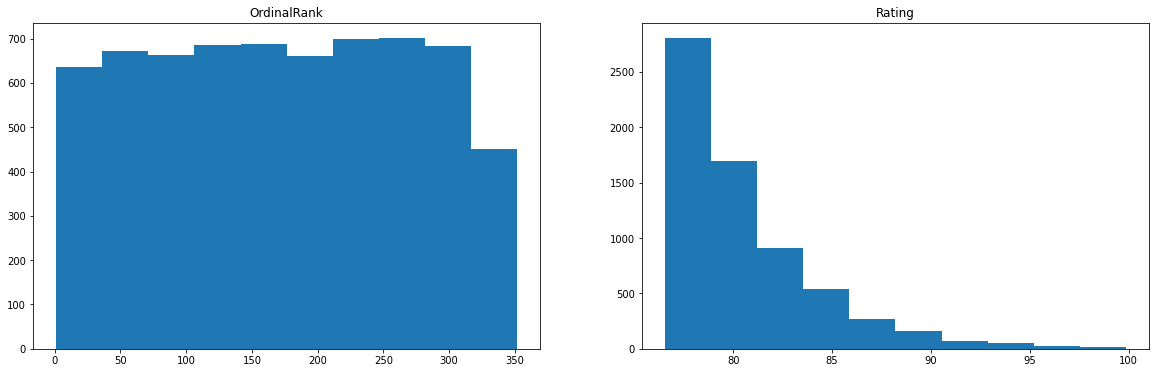

In [ ]:
f = plt.figure(figsize=(20,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.hist(ordinals["OrdinalRank"])
ax1.set_title("OrdinalRank")
ax2.hist(ordinals["Rating"])
ax2.set_title("Rating")

***[Explain]***:

Trước đó ta thấy: Miền giá trị của OrdinalRank (thứ hạng) nằm trong [1-351]. Có lẽ vì giá trị của Rating khá dàn trải, cũng như muốn mô hình train được hiệu quả hơn nên tác giả đã scale lại giá trị này với hàm log. Đồng thời, do muốn thể hiện rằng thứ hạng càng cao thì rating càng cao và đưa giá trị về một khoảng với max = 100 nên đã có công thức bên dưới:

$$\textrm{Y} = 100 - 4 \times log({X}) $$

Lúc này giá trị của cột Rating từ **[1-351] -> [76 - 100]**. Ngoài ra, phân bố của Rating cũng cho thấy sự tách biệt rõ ràng hơn giữa nhóm các đội thứ hạng cao và thứ hạng thấp so với OrdinalRank.

**Note**: Ngoài Rating, các thuộc tính khác khá đơn giản nên việc xử lý code sẽ khá tương đồng so với tác giả, tuy nhiên sẽ được viết lại và chỉnh sửa cho gọn hơn.

#### 2. Tính số trận thắng/thua của đội trong mùa giải
***[Explain]***

Giải đấu áp dụng hình thức loại trực tiếp, tức những đội có số trận thắng nhiều đồng nghĩa với việc tiến sâu vào giải, vậy nên trên lí thuyết, đây khả năng đều là những đội mạnh, tỉ lệ thắng khi gặp một đội khác hẳn sẽ cao hơn 1 đội có nhiều trận thua.

- Dựa vào bảng *MRegularSeasonDetailedResults*, tính số trận thắng / trận thua của các đội trong mùa giải

* **INPUT**: *MRegularSeasonDetailedResults.csv* có rất nhiều cột 
* **OUTPUT**: bảng win_lose gồm các cột **Season;	TeamID;	NumWins;	NumLoses**

In [ ]:
regular_results

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,...,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,...,16,17,27,21,15,12,10,7,1,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96682,2021,132,1104,80,1261,79,N,0,33,76,...,27,9,13,15,26,10,5,6,5,13
96683,2021,132,1159,85,1259,72,H,0,31,59,...,22,9,16,12,19,12,12,2,1,13
96684,2021,132,1222,91,1153,54,N,0,37,66,...,33,10,15,14,17,11,10,2,5,12
96685,2021,132,1228,91,1326,88,N,1,29,64,...,25,22,30,8,27,11,8,7,4,26


In [ ]:
# Đếm số tận thắng
num_win = regular_results.groupby(['Season', 'WTeamID']).count()
num_win = num_win.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns={"DayNum": "NumWins", "WTeamID": "TeamID"})
# Đếm số trận thua
num_lose = regular_results.groupby(['Season', 'LTeamID']).count()
num_lose = num_lose.reset_index()[['Season', 'LTeamID', 'DayNum']].rename(columns={"DayNum": "NumLoses", "LTeamID": "TeamID"})
# Ghép 2 bảng lại
win_lose = pd.merge(num_win, num_lose, how='outer', on=['Season', 'TeamID']).fillna(0).sort_values(by=['Season','TeamID']).reset_index(drop=True)
win_lose

,Season,TeamID,NumWins,NumLoses
0,2003,1102,12.0,16.0
1,2003,1103,13.0,14.0
2,2003,1104,17.0,11.0
3,2003,1105,7.0,19.0
4,2003,1106,13.0,15.0
...,...,...,...,...
6529,2021,1467,9.0,9.0
6530,2021,1468,11.0,7.0
6531,2021,1469,6.0,13.0
6532,2021,1470,5.0,10.0


Text(0.5, 1.0, 'NumLoses')

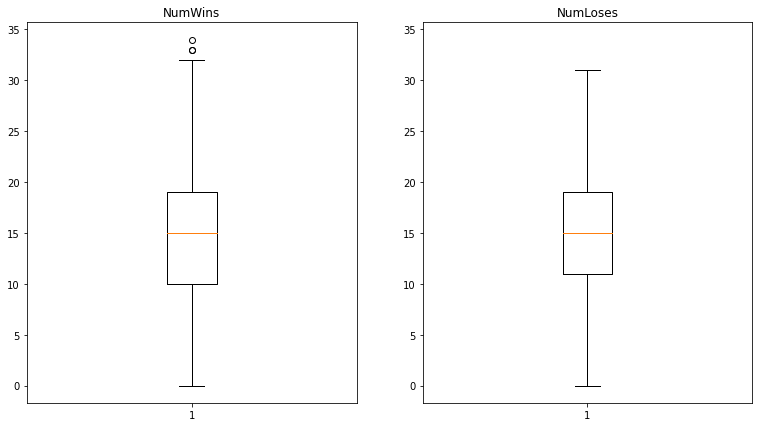

In [ ]:
f = plt.figure(figsize=(13,7))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122,sharey=ax1)

ax1.boxplot(win_lose["NumWins"])
ax1.set_title("NumWins")
ax2.boxplot(win_lose["NumLoses"])
ax2.set_title("NumLoses")

#### 3. Thống kê trung bình số liệu của đội trong mỗi mùa giải
***[EXPLAIN:]***

Theo  [Wiki](https://en.wikipedia.org/wiki/Basketball_statistics) và [Basketball Statistics Definitions](https://www.breakthroughbasketball.com/stats/definitions.html) thì đây là các thông số để đánh giá một cầu thủ (hoặc khả năng của một đội)
* FGM	FGA: (Feild Goal Made | Attempt)
* FGM3 FGA3	: (3 point) [Image](https://www.wikihow.com/images/thumb/3/3b/Shoot-a-Three-Pointer-Step-1-Version-7.jpg/v4-460px-Shoot-a-Three-Pointer-Step-1-Version-7.jpg.webp)
* FTM	FTA: (Free Throw) [Image](https://media.istockphoto.com/vectors/man-shooting-a-basketball-into-a-hoop-and-scoring-from-free-throw-vector-id1303771934?k=20&m=1303771934&s=612x612&w=0&h=R7sT2iTMIMZ_DSiKVl99l1KXj3BUZP6LpXf_JiE_uho=)
* OR	DR: (Offensive | Defensive) Rebound [Link](https://www.rookieroad.com/basketball/stats/rebounds/)
*	Ast:	(Assist) Hỗ trợ ghi điểm 
* TO: (TurnOver) Phản công thành công khi đối phương mất cơ hội	
* Stl: (Steal) Cướp bóng thành công
* Blk: (Block) Chặn bóng thành công
* PF: (Personal Fouls)


Dựa vào bảng MRegularSeasonDetailedResults, thống kê số liệu trận đấu trung bình của đội trong mùa giải.

***Bước 1:*** 
* **INPUT**: MRegularSeasonDetailedResults.csv có rất nhiều cột ghi lại thông số từng trận mỗi mùa
* **OUPUT**: *wteam_stats* Tính trung bình thông số (mỗi Season) của các đội, chỉ tính trận thắng 

***Bước 2:*** 
* **INPUT**: MRegularSeasonDetailedResults.csv có rất nhiều cột ghi lại thông số từng trận mỗi mùa
* **OUPUT**: *lteam_stats* Tính trung bình thông số (mỗi Season) của các đội, chỉ tính trận thua

***Bước 3:*** 
* **INPUT**: Gom *wteam_stats* và *lteam_stats*
* **OUPUT**: Trung bình thông số mỗi đội từ 2 bảng trên

*Bước 1* 

In [ ]:
# Tính trung bình số liệu trận thắng của mỗi đội theo mùa
wteam_stats = regular_results.groupby(['Season', 'WTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thua
wteam_stats = wteam_stats.drop(['DayNum','LTeamID', 'NumOT','LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 
                                'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF',], axis=1)
# Đổi tên các thuộc tính của đội thắng thành tên chung
wteam_stats = wteam_stats.rename(columns={"WTeamID": "TeamID", 'WScore':'Score','LScore':'Scored', 'WFGM':'FGM',
                                        'WFGA':'FGA', 'WFGM3':'FGM3','WFGA3':'FGA3', 'WFTM':'FTM', 'WFTA':'FTA',
                                        'WOR':'OR', 'WDR':'DR','WAst':'Ast','WTO':'TO','WStl':'Stl','WBlk':'Blk','WPF':'PF'})
wteam_stats

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,68.750000,53.166667,22.583333,40.000000,10.000000,21.583333,13.583333,20.750000,3.833333,19.333333,16.916667,11.083333,7.333333,2.833333,16.083333
1,2003,1103,87.769231,78.384615,30.000000,55.384615,5.461538,14.384615,22.307692,30.923077,9.384615,21.461538,17.692308,12.538462,7.307692,1.846154,20.461538
2,2003,1104,74.705882,61.529412,25.823529,58.352941,7.058824,20.823529,16.000000,22.529412,13.529412,26.411765,14.000000,13.058824,7.235294,4.176471,16.470588
3,2003,1105,79.428571,66.428571,25.571429,61.857143,9.142857,22.428571,19.142857,25.714286,14.571429,25.857143,15.857143,18.000000,11.285714,2.000000,19.428571
4,2003,1106,68.307692,57.923077,24.769231,53.846154,5.846154,15.923077,12.923077,20.769231,12.769231,28.000000,13.000000,17.692308,9.384615,3.769231,18.384615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6523,2021,1467,71.000000,61.777778,25.888889,53.000000,7.111111,21.777778,12.111111,17.888889,5.777778,25.000000,13.444444,13.888889,8.222222,3.888889,3.555556
6524,2021,1468,76.000000,62.363636,28.363636,55.181818,6.636364,18.454545,12.636364,16.181818,7.545455,21.636364,15.909091,10.636364,7.181818,2.272727,1.636364
6525,2021,1469,76.666667,71.833333,25.833333,59.166667,6.833333,19.833333,18.166667,23.500000,7.500000,23.833333,15.000000,12.666667,7.333333,1.666667,3.333333
6526,2021,1470,69.000000,56.200000,24.000000,50.800000,5.800000,12.800000,15.200000,18.400000,3.800000,22.800000,14.400000,8.000000,6.200000,2.000000,15.000000


*Bước 2:* 

In [ ]:
# Tính trung bình số liệu trận thua của mỗi đội theo mùa
lteam_stats = regular_results.groupby(['Season', 'LTeamID']).mean().reset_index()
# Loại bỏ các thuộc tính của đội thắng
lteam_stats = lteam_stats.drop(['DayNum', 'WTeamID', 'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM',
                                'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)
# Đổi tên các thuộc tính của đội thua thành tên chung
lteam_stats = lteam_stats.rename(columns={"LTeamID": "TeamID", 'LScore':'Score','WScore':'Scored', 'LFGM':'FGM',
                                        'LFGA':'FGA', 'LFGM3':'FGM3','LFGA3':'FGA3', 'LFTM':'FTM', 'LFTA':'FTA',
                                        'LOR':'OR', 'LDR':'DR','LAst':'Ast','LTO':'TO','LStl':'Stl','LBlk':'Blk','LPF':'PF'})
lteam_stats

,Season,TeamID,Scored,Score,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,59.875000,48.625000,16.562500,39.625000,6.187500,20.250000,9.312500,14.375000,4.437500,14.937500,10.062500,11.687500,4.937500,1.000000,20.750000
1,2003,1103,77.928571,70.428571,24.500000,56.285714,5.428571,17.642857,16.000000,21.142857,10.142857,18.500000,12.928571,12.714286,7.214286,2.785714,19.285714
2,2003,1104,70.363636,60.909091,21.272727,55.363636,5.272727,18.363636,13.090909,18.454545,13.636364,20.090909,9.181818,13.636364,5.636364,3.181818,20.454545
3,2003,1105,80.421053,68.947368,23.947368,61.526316,7.000000,20.157895,14.052632,20.421053,13.105263,22.105263,14.052632,18.894737,8.578947,2.105263,20.526316
4,2003,1106,68.800000,59.533333,22.266667,56.533333,6.333333,19.133333,8.666667,12.733333,11.866667,20.266667,10.533333,16.466667,7.466667,2.600000,18.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6526,2021,1467,71.555556,61.555556,22.333333,54.444444,6.888889,22.444444,10.000000,15.444444,5.777778,19.222222,10.555556,12.111111,7.777778,3.666667,11.777778
6527,2021,1468,77.571429,67.142857,25.571429,53.428571,5.857143,14.857143,10.142857,14.428571,5.428571,17.000000,14.142857,11.142857,5.714286,1.714286,4.285714
6528,2021,1469,81.153846,63.461538,22.230769,57.230769,5.384615,19.615385,13.615385,19.076923,7.769231,22.846154,14.153846,16.461538,6.461538,2.230769,4.769231
6529,2021,1470,74.100000,61.300000,21.000000,50.900000,5.300000,15.500000,14.000000,19.900000,4.700000,18.800000,9.800000,12.400000,7.000000,2.400000,2.600000


*Bước 3*

In [ ]:
# Ghép 2 số liệu của các trận thắng và thua lại
regular_season_feature = pd.concat([wteam_stats, lteam_stats], 0).reset_index(drop=True)
# Tính trung bình
regular_season_feature = regular_season_feature.groupby(['Season', 'TeamID']).mean().reset_index()
regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,4.135417,17.135417,13.489583,11.385417,6.135417,1.916667,18.416667
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,9.763736,19.980769,15.310440,12.626374,7.260989,2.315934,19.873626
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,13.582888,23.251337,11.590909,13.347594,6.435829,3.679144,18.462567
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,13.838346,23.981203,14.954887,18.447368,9.932331,2.052632,19.977444
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,12.317949,24.133333,11.766667,17.079487,8.425641,3.184615,18.192308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,5.777778,22.111111,12.000000,13.000000,8.000000,3.777778,7.666667
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,6.487013,19.318182,15.025974,10.889610,6.448052,1.993506,2.961039
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,7.634615,23.339744,14.576923,14.564103,6.897436,1.948718,4.051282
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,4.250000,20.800000,12.100000,10.200000,6.600000,2.200000,8.800000



#### 4. Tính và thêm các thuộc tính Scoregap, FG%, 3P%, FT%, TR, TS%, eFG%, OR%, TOV%, FreeThrows, POSS, PPP
***[EXPLAIN]***
- Scoregap: Hiệu số điểm của đội
- FG%: Hiệu suất ghi bàn [Link](https://jr.nba.com/field-goal-percentage-fg/)
- 3P%: Hiệu suất cú ném 3 điểm [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- FT%: (Free Throws) Hiệu suất cú ném tự do [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- TR: (Total Rebound) Tổng số lần bắt bóng bật bảng [Link](https://www.basketball-reference.com/about/glossary.html#:~:text=3P%25%20%2D%203%2DPoint%20Field,the%20formula%20is%203P%20%2F%203PA.&text=Block%20percentage%20is%20an%20estimate,he%20was%20on%20the%20floor.)
- TS%: (True Shooting): Ghi điểm từ cú ném bóng chính xác [Link](https://www.nbastuffer.com/analytics101/true-shooting-percentage/)
$$TS = 0.5* Score /  [FGA + 0.44* FTA]$$
- TOV%: Ước lượng khả năng xảy ra Turnover [Link](https://www.basketball-reference.com/about/glossary.html)
$$ TOV = TO / [FGA + 0.44 * FTA + TO]$$
- eFG% Hiệu quả của các cú ném [Link](https://www.nbastuffer.com/analytics101/effective-field-goal-percentage-efg/)
$$eFG = [FGM + 0.5*(FGM3)]/FGA$$
- POSS (Possessions), PPP (Points Per Possessions): hiệu suất biến cơ hội thành bàn thắng. [Link](https://www.nbastuffer.com/analytics101/points-per-possession-ppp/)
$$PPP=Score/[FGA+0.44*FTA+TO]$$

Four-Factor: Theo Oliver Dean thì 4 yếu tố thành công gồm: eFG% (Effective Field Goal Percentage), OR% (Offensive Rebound), TOV% (Turnovers), FreeThrows.

* **INPUT**: Bảng *regular_season_feature* đã có giá trị Trung bình thông số mỗi đội
* **OUTPUT**: Bảng *regular_season_feature* Thêm các cột phía trên

In [ ]:
########Có thể tự suy ra
# Score-gap: Độ hiệu số điểm
regular_season_feature['Scoregap'] = regular_season_feature['Score'] - regular_season_feature['Scored']
# FG%: Hiệu suất ghi bàn
regular_season_feature['FG%'] = regular_season_feature['FGM']/regular_season_feature['FGA']
# 3P%: Hiệu suất cú ném 3 điểm
regular_season_feature['3P%'] = regular_season_feature['FGM3']/regular_season_feature['FGA3']
# FT% (Free Throws Percentage): Hiệu suất cú ném tự do
regular_season_feature['FT%'] = regular_season_feature['FTM']/regular_season_feature['FTA']
# EV(expect value)
regular_season_feature['EV'] = regular_season_feature['FGM']*regular_season_feature['FG%'] \
                            + regular_season_feature['FGM3']*regular_season_feature['3P%'] \
                            + regular_season_feature['FTM']*regular_season_feature['FT%'] \
# TR (Total Rebounds)
regular_season_feature['TR'] = regular_season_feature['OR'] + regular_season_feature['DR']
# OR% (Offensive Rebound): Tỉ lệ thực hiện Rebound khi tấn công
regular_season_feature['OR%'] = regular_season_feature['OR']/regular_season_feature['FGA']
# FreeThrowsRatios
regular_season_feature['FreeThrows'] = regular_season_feature['FTM']/regular_season_feature['FGA']


#########Cần công thức
# TS% (True Shooting Percentage)
regular_season_feature['TS%'] = regular_season_feature['Score']/(2*(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA']))

# eFG% (Effective Field Goal Percentage)
regular_season_feature['eFG%'] = (regular_season_feature['FGM'] +0.5*regular_season_feature['FGM3'])/regular_season_feature['FGA']

# TOV% (Turnovers)
regular_season_feature['TOV%'] = regular_season_feature['TO']/(regular_season_feature['FGA'] + 0.44*regular_season_feature['FTA'] +regular_season_feature['TO'])

# PPP/POSS (Possessions)
regular_season_feature['POSS'] = regular_season_feature['FGA'] +0.44*regular_season_feature['FTA'] + regular_season_feature['TO']
# PPP (Points Per Possessions)
regular_season_feature['PPP'] = regular_season_feature['Score']/regular_season_feature['POSS']

# Win-Lose
regular_season_feature = regular_season_feature.merge(win_lose, on=['Season', 'TeamID'],how='left').reset_index(drop=True)
regular_season_feature['WinRatio'] = regular_season_feature['NumWins']/(regular_season_feature['NumWins'] + regular_season_feature['NumLoses'])

regular_season_feature

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,...,OR%,FreeThrows,TS%,eFG%,TOV%,POSS,PPP,NumWins,NumLoses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,...,0.103872,0.287546,0.617243,0.593276,0.193217,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,...,0.174867,0.343043,0.587749,0.536804,0.157995,79.916044,0.989775,13.0,14.0,0.481481
2,2003,1104,67.807487,65.946524,23.548128,56.858289,6.165775,19.593583,14.545455,20.491979,...,0.238890,0.255819,0.514670,0.468375,0.168483,79.222353,0.855914,17.0,11.0,0.607143
3,2003,1105,74.187970,73.424812,24.759398,61.691729,8.071429,21.293233,16.597744,23.067669,...,0.224314,0.269043,0.516331,0.466758,0.204315,90.288872,0.821673,7.0,19.0,0.269231
4,2003,1106,63.920513,63.361538,23.517949,55.189744,6.089744,17.528205,10.794872,16.751282,...,0.223193,0.195596,0.510871,0.481300,0.214459,79.639795,0.802620,13.0,15.0,0.464286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6529,2021,1467,66.277778,66.666667,24.111111,53.722222,7.000000,22.111111,11.055556,16.666667,...,0.107549,0.205791,0.542766,0.513961,0.175544,74.055556,0.894974,9.0,9.0,0.500000
6530,2021,1468,71.571429,69.967532,26.967532,54.305195,6.246753,16.655844,11.389610,15.305195,...,0.119455,0.209733,0.586272,0.554107,0.151394,71.929091,0.995028,11.0,7.0,0.611111
6531,2021,1469,70.064103,76.493590,24.032051,58.198718,6.108974,19.724359,15.891026,21.288462,...,0.131182,0.273048,0.518489,0.465415,0.177330,82.129744,0.853090,6.0,13.0,0.315789
6532,2021,1470,65.150000,65.150000,22.500000,50.850000,5.550000,14.150000,14.600000,19.150000,...,0.083579,0.287119,0.549548,0.497050,0.146813,69.476000,0.937734,5.0,10.0,0.333333


#### 5. Ghép các bảng lại
- Nối các thuộc tính vừa tính được lại với nhau

* **INPUT:** Bảng tourney_results chứa MNCAATourneyCompactResults.csv gồm **Season; DayNum; WTeamID; WScore; LTeamID; LScore; WLoc; NumOT**
* **OUTPUT:** Bảng tourney_results với
    * Các mẫu lấy Season >=2003
    * Merge với regular_season_feature để có toàn bộ chỉ số đội thắng (Season và WTeamID)
    * Merge với ordinals để có Rating đội thắng (WRating)
    * Merge với regular_season_feature để có toàn bộ chỉ số đội thua (Season và LTeamID)
    * Merge với ordinals để có Rating đội thua (LRating)
    
**Note**: Bước này tiến hành tương tự tác giả.

**Giải thích các bước**:

Cần nối MNCAATourneyCompactResults.csv + regular_season_feature + ordinals

In [ ]:
TourneyCompact = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0


In [ ]:
regular_season_feature.head(2)

,Season,TeamID,Score,Scored,FGM,FGA,FGM3,FGA3,FTM,FTA,...,OR%,FreeThrows,TS%,eFG%,TOV%,POSS,PPP,NumWins,NumLoses,WinRatio
0,2003,1102,58.687500,56.520833,19.572917,39.812500,8.093750,20.916667,11.447917,17.562500,...,0.103872,0.287546,0.617243,0.593276,0.193217,58.925417,0.995962,12.0,16.0,0.428571
1,2003,1103,79.098901,78.156593,27.250000,55.835165,5.445055,16.013736,19.153846,26.032967,...,0.174867,0.343043,0.587749,0.536804,0.157995,79.916044,0.989775,13.0,14.0,0.481481


In [ ]:
ordinals.head(2)

,Season,TeamID,OrdinalRank,Rating
0,2003,1102,154.058824,79.850662
1,2003,1103,168.705882,79.487373


In [ ]:
#Lọc 2003 trở đi
TourneyCompact = TourneyCompact[TourneyCompact.Season >= 2003].reset_index(drop=True)

Nối với đội Win

In [ ]:
#ghép với regular_season_feature dựa trên mùa giải và đội thắng
TourneyCompact = TourneyCompact.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
#đổi tên cột tương ứng cho chỉ số đội WIN
TourneyCompact.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(5)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,...,OR%W,FreeThrowsW,TS%W,eFG%W,TOV%W,POSSW,PPPW,NumWinsW,NumLosesW,WinRatioW
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.215828,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.238247,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.237605,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,...,0.210620,0.340180,0.581668,0.528337,0.225118,81.728406,0.901448,23.0,6.0,0.793103
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,...,0.196927,0.201522,0.536484,0.506571,0.169963,82.160714,0.890603,21.0,8.0,0.724138


In [ ]:
#ghép với ordinals dựa trên đội thắng
TourneyCompact = TourneyCompact.merge(ordinals[['Season', 'TeamID', 'Rating']],
                     left_on=['Season', 'WTeamID'],
                     right_on=['Season', 'TeamID'], 
                    how='left')
#đổi tên cột tương ứng cho chỉ số đội WIN
TourneyCompact.rename(columns={'Rating':'RatingW'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,...,FreeThrowsW,TS%W,eFG%W,TOV%W,POSSW,PPPW,NumWinsW,NumLosesW,WinRatioW,RatingW
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.284235,0.543616,0.490556,0.195465,82.298750,0.874715,13.0,16.0,0.448276,78.036478
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.238247,0.513412,0.472867,0.156402,94.201600,0.866227,25.0,3.0,0.892857,96.160897
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.298486,0.543732,0.501567,0.170127,82.499293,0.902456,18.0,11.0,0.620690,85.692154


Nối với đội thua

In [ ]:
#ghép với regular_season_feature dựa trên mùa giải và đội thua
TourneyCompact = TourneyCompact.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
#đổi tên cột tương ứng cho chỉ số đội LOSE
TourneyCompact.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,...,OR%L,FreeThrowsL,TS%L,eFG%L,TOV%L,POSSL,PPPL,NumWinsL,NumLosesL,WinRatioL
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.242008,0.300699,0.530262,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.229767,0.218661,0.511484,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.238067,0.261546,0.518125,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103


In [ ]:
#ghép với ordinals dựa trên đội thua
TourneyCompact = TourneyCompact.merge(ordinals[['Season', 'TeamID', 'Rating']],
                                      left_on=['Season', 'LTeamID'],
                                      right_on=['Season', 'TeamID'], 
                                        how='left')
TourneyCompact.rename(columns={'Rating':'RatingL'},inplace = True)
TourneyCompact.drop(columns='TeamID', axis=1,inplace = True)
TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,ScoreW,ScoredW,...,FreeThrowsL,TS%L,eFG%L,TOV%L,POSSL,PPPL,NumWinsL,NumLosesL,WinRatioL,RatingL
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.300699,0.530262,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000,78.102523
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.218661,0.511484,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172,79.873637
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.261546,0.518125,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103,87.362553


#### Kết Quả

In [ ]:
tourney_results = pd.read_csv(datasets_path + 'MNCAATourneyCompactResults.csv')
# Lấy thông tin mùa giải 2003 đến nay
tourney_results = tourney_results[tourney_results['Season'] >= 2003].reset_index(drop=True)
# Ghép mã các đội thắng với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={ 'NumWins': 'NumWinsW', 'NumLoses':'NumLosesW', 'WinRatio': 'WinRatioW',
                                                 'FGM':'FGMW', 'FGA':'FGAW', 'FGM3':'FGM3W','FGA3':'FGA3W', 'FTM':'FTMW','FTA':'FTAW',
                                                 'OR':'ORW','DR':'DRW','Ast':'AstW','TO':'TOW','Stl':'StlW','Blk':'BlkW','PF':'PFW',
                                                 'FG%':'FG%W','3P%':'3P%W','FT%':'FT%W','eFG%':'eFG%W','TOV%':'TOV%W',
                                                 'FreeThrows':'FreeThrowsW', 'POSS':'POSSW','PPP':'PPPW','TS%':'TS%W','EV':'EVW','TR':'TRW','OR%':'OR%W',
                                                 'Score':'ScoreW', 'Scored':'ScoredW','Scoregap':'ScoregapW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thắng với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'WTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingW'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 4 theo mùa giải
tourney_results = tourney_results.merge(regular_season_feature, left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], how='left')
# Đổi tên thuộc tính
tourney_results = tourney_results.rename(columns={'NumWins': 'NumWinsL', 'NumLoses':'NumLosesL', 'WinRatio': 'WinRatioL',
                                                'FGM':'FGML', 'FGA':'FGAL', 'FGM3':'FGM3L','FGA3':'FGA3L', 'FTM':'FTML', 'FTA':'FTAL', 'OR':'ORL', 
                                                'DR':'DRL','Ast':'AstL','TO':'TOL','Stl':'StlL','Blk':'BlkL','PF':'PFL',
                                                'FG%':'FG%L','3P%':'3P%L','FT%':'FT%L','eFG%':'eFG%L','TOV%':'TOV%L','FreeThrows':'FreeThrowsL',
                                                'POSS':'POSSL','PPP':'PPPL','TS%':'TS%L','EV':'EVL','TR':'TRL','OR%':'OR%L','Score':'ScoreL',
                                                'Scored':'ScoredL','Scoregap':'ScoregapL'}).drop(columns='TeamID', axis=1)
# Ghép mã các đội thua với bảng ở mục 1 theo mùa giải
tourney_results = tourney_results.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'LTeamID'], right_on=['Season', 'TeamID'], 
                                        how='left').rename(columns={'Rating':'RatingL'}).drop(columns='TeamID', axis=1)
tourney_results.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'ScoreW', 'ScoredW', 'FGMW', 'FGAW', 'FGM3W', 'FGA3W', 'FTMW',
       'FTAW', 'ORW', 'DRW', 'AstW', 'TOW', 'StlW', 'BlkW', 'PFW', 'ScoregapW',
       'FG%W', '3P%W', 'FT%W', 'EVW', 'TRW', 'OR%W', 'FreeThrowsW', 'TS%W',
       'eFG%W', 'TOV%W', 'POSSW', 'PPPW', 'NumWinsW', 'NumLosesW', 'WinRatioW',
       'RatingW', 'ScoreL', 'ScoredL', 'FGML', 'FGAL', 'FGM3L', 'FGA3L',
       'FTML', 'FTAL', 'ORL', 'DRL', 'AstL', 'TOL', 'StlL', 'BlkL', 'PFL',
       'ScoregapL', 'FG%L', '3P%L', 'FT%L', 'EVL', 'TRL', 'OR%L',
       'FreeThrowsL', 'TS%L', 'eFG%L', 'TOV%L', 'POSSL', 'PPPL', 'NumWinsL',
       'NumLosesL', 'WinRatioL', 'RatingL'],
      dtype='object')

#### 6. Hàm thiết lập đầu vào

file "MSampleSubmissionStage2.csv" gồm **ID; Pred** với ID có dạng "Season_TeamIdA_TeamIdB" nên cần đổi về dạng phù hợp.

* **INPUT:** tourney_results với các cột có dạng W-L
* **OUTPUT** tourney_results với các cột có dạng A-B
  * Thay đổi W-LTeam sang A-BTeam



In [ ]:
def add_loosing_matches(win_df):
    win_rename = {
        "WTeamID": "TeamIdA", 
        "WScore" : "Score1", 
        "LTeamID" : "TeamIdB",
        "LScore": "Score2",
        'FGMW':'FGMA', 
        'FGAW':'FGAA', 
        'FGM3W':'FGM3A',
        'FGA3W':'FGA3A',
        'FTMW':'FTMA', 
        'FTAW':'FTAA', 
        'ORW':'ORA', 
        'DRW':'DRA',
        'AstW':'AstA',
        'TOW':'TOA',
        'StlW':'StlA',
        'BlkW':'BlkA',
        'PFW':'PFA',
        'FG%W':'FG%A',
        '3P%W':'3P%A',
        'FT%W':'FT%A',
        'eFG%W':'eFG%A',
        'TOV%W':'TOV%A',
        'FreeThrowsW':'FreeThrowsA',
        'POSSW':'POSSA',
        'PPPW':'PPPA',
        'TS%W':'TS%A',
        'EVW':'EVA',
        'TRW':'TRA',
        'OR%W':'OR%A',
        'ScoreW':'ScoreA',
        'ScoredW':'ScoredA',
        'ScoregapW':'ScoregapA',
        'NumWinsW': 'NumWinsA', 
        'NumLosesW':'NumLosesA', 
        'WinRatioW':'WinRatioA',
        'RatingW': 'RatingA',
        'FGML':'FGMB',
        'FGAL':'FGAB', 
        'FGM3L':'FGM3B',
        'FGA3L':'FGA3B',
        'FTML':'FTMB', 
        'FTAL':'FTAB', 
        'ORL':'ORB',
        'DRL':'DRB',
        'AstL':'AstB',
        'TOL':'TOB',
        'StlL':'StlB',
        'BlkL':'BlkB',
        'PFL':'PFB',
        'FG%L':'FG%B',
        '3P%L':'3P%B',
        'FT%L':'FT%B',
        'eFG%L':'eFG%B',
        'TOV%L':'TOV%B',
        'FreeThrowsL':'FreeThrowsB',
        'POSSL':'POSSB',
        'PPPL':'PPPB',
        'TS%L':'TS%B',
        'EVL':'EVB',
        'TRL':'TRB',
        'OR%L':'OR%B',
        'ScoreL':'ScoreB',
        'ScoredL':'ScoredB',
        'ScoregapL':'ScoregapB',
        'NumWinsL': 'NumWinsB',
        'NumLosesL':'NumLosesB', 
        'WinRatioL':'WinRatioB',
        'RatingL': 'RatingB',
     }
    
    lose_rename = {
        "WTeamID": "TeamIdB", 
        "WScore" : "Score2", 
        "LTeamID" : "TeamIdA",
        "LScore": "Score1",
        'FGMW':'FGMB', 
        'FGAW':'FGAB', 
        'FGM3W':'FGM3B',
        'FGA3W':'FGA3B',
        'FTMW':'FTMB', 
        'FTAW':'FTAB', 
        'ORW':'ORB', 
        'DRW':'DRB',
        'AstW':'AstB',
        'TOW':'TOB',
        'StlW':'StlB',
        'BlkW':'BlkB',
        'PFW':'PFB',
        'FG%W':'FG%B',
        '3P%W':'3P%B',
        'FT%W':'FT%B',
        'eFG%W':'eFG%B',
        'TOV%W':'TOV%B',
        'FreeThrowsW':'FreeThrowsB',
        'POSSW':'POSSB',
        'PPPW':'PPPB',
        'TS%W':'TS%B',
        'EVW':'EVB',
        'TRW':'TRB',
        'OR%W':'OR%B',
        'ScoreW':'ScoreB',
        'ScoredW':'ScoredB',
        'ScoregapW':'ScoregapB',
        'NumWinsW': 'NumWinsB', 
        'NumLosesW':'NumLosesB', 
        'WinRatioW':'WinRatioB',
        'RatingW': 'RatingB',
        'FGML':'FGMA',
        'FGAL':'FGAA', 
        'FGM3L':'FGM3A',
        'FGA3L':'FGA3A',
        'FTML':'FTMA', 
        'FTAL':'FTAA', 
        'ORL':'ORA',
        'DRL':'DRA',
        'AstL':'AstA',
        'TOL':'TOA',
        'StlL':'StlA',
        'BlkL':'BlkA',
        'PFL':'PFA',
        'FG%L':'FG%A',
        '3P%L':'3P%A',
        'FT%L':'FT%A',
        'eFG%L':'eFG%A',
        'TOV%L':'TOV%A',
        'FreeThrowsL':'FreeThrowsA',
        'POSSL':'POSSA',
        'PPPL':'PPPA',
        'TS%L':'TS%A',
        'EVL':'EVA',
        'TRL':'TRA',
        'OR%L':'OR%A',
        'ScoreL':'ScoreA',
        'ScoredL':'ScoredA',
        'ScoregapL':'ScoregapA',
        'NumWinsL': 'NumWinsA',
        'NumLosesL':'NumLosesA', 
        'WinRatioL':'WinRatioA',
        'RatingL': 'RatingA',
    }
    
    win_df = win_df.copy()
    lose_df = win_df.copy()
    
    win_df = win_df.rename(columns=win_rename)
    lose_df = lose_df.rename(columns=lose_rename)
    
    return pd.concat([win_df, lose_df], 0, sort=False)

In [ ]:
tourney_results = add_loosing_matches(tourney_results)
tourney_results['ScoreDiff'] = tourney_results['Score1'] - tourney_results['Score2']
tourney_results['WinA'] = (tourney_results['ScoreDiff'] > 0).astype(int)
tourney_results

,Season,DayNum,TeamIdA,Score1,TeamIdB,Score2,WLoc,NumOT,ScoreA,ScoredA,...,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB,ScoreDiff,WinA
0,2003,134,1421,92,1411,84,N,1,71.987981,77.951923,...,0.494006,0.181236,82.535000,0.868318,18.0,12.0,0.600000,78.102523,8,1
1,2003,136,1112,80,1436,51,N,0,81.600000,75.126667,...,0.478279,0.181825,78.849789,0.836968,19.0,10.0,0.655172,79.873637,29,1
2,2003,136,1113,84,1272,71,N,0,74.452020,71.030303,...,0.478428,0.157624,84.865072,0.872912,23.0,6.0,0.793103,87.362553,13,1
3,2003,136,1141,79,1166,73,N,0,73.673913,74.753623,...,0.538211,0.172487,79.066207,0.945029,29.0,4.0,0.878788,87.945493,6,1
4,2003,136,1143,76,1301,74,N,1,73.172619,73.044643,...,0.520093,0.186531,76.618333,0.927034,18.0,12.0,0.600000,84.342776,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1110,2019,146,1246,71,1120,77,N,1,75.601852,72.712963,...,0.526372,0.160476,81.161511,0.939964,25.0,9.0,0.735294,89.346992,-6,0
1111,2019,146,1181,67,1277,68,N,0,81.389655,75.024138,...,0.552164,0.177015,79.223810,0.966896,28.0,6.0,0.823529,93.460691,-1,0
1112,2019,152,1277,51,1403,61,N,0,76.601190,70.428571,...,0.501902,0.173606,76.728205,0.892010,26.0,6.0,0.812500,90.632777,-10,0
1113,2019,152,1120,62,1438,63,N,0,76.288889,72.062222,...,0.542067,0.134805,70.216552,0.990123,29.0,3.0,0.906250,97.585860,-1,0


### IV. Train

#### 1. Đọc file Submission
- Đọc dữ liệu từ file Submission
- Xử lý chuỗi để lấy ra thuộc tính Season, TeamID
Bảng test "MSampleSubmissionStage2.csv" gồm **ID; Pred** với ID có dạng "Season_TeamIdA_TeamIdB" nên cần đổi về dạng phù hợp.

* **INPUT:** Bảng test "MSampleSubmissionStage2.csv" gồm **ID; Pred**
* **OUTPUT** Bảng test gồm **ID	Pred	Season	TeamIdA	TeamIdB**

In [ ]:
test = pd.read_csv(datasets_path + "MSampleSubmissionStage2.csv")
test['Season'] = test['ID'].apply(lambda x: int(x.split('_')[0]))
test['TeamIdA'] = test['ID'].apply(lambda x: int(x.split('_')[1]))
test['TeamIdB'] = test['ID'].apply(lambda x: int(x.split('_')[2]))
test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2021_1101_1104,0.5,2021,1101,1104
1,2021_1101_1111,0.5,2021,1101,1111
2,2021_1101_1116,0.5,2021,1101,1116
3,2021_1101_1124,0.5,2021,1101,1124
4,2021_1101_1140,0.5,2021,1101,1140


#### 2. Ghép ID của mỗi đội với các thuộc tính có
* **INPUT** Bảng test gồm ID Pred Season TeamIdA TeamIdB
* **OUTPUT** Bảng test và các chỉ số tương ứng các đội đã tính trước đó, đây là data để predict
    * Merge với regular_season_feature để có toàn bộ chỉ số đội A 
    * Merge với ordinals để có Rating đội A
    * Merge với regular_season_feature để có toàn bộ chỉ số đội B 
    * Merge với ordinals để có Rating đội B

In [ ]:
test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsA', 'NumLoses':'NumLosesA', 'WinRatio': 'WinRatioA',
                'FGM':'FGMA', 'FGA':'FGAA', 'FGM3':'FGM3A','FGA3':'FGA3A', 'FTM':'FTMA', 'FTA':'FTAA', 'OR':'ORA', 
                'DR':'DRA','Ast':'AstA','TO':'TOA','Stl':'StlA','Blk':'BlkA','PF':'PFA',
                'FG%':'FG%A','3P%':'3P%A','FT%':'FT%A','eFG%':'eFG%A','TOV%':'TOV%A','FreeThrows':'FreeThrowsA',
                'POSS':'POSSA','PPP':'PPPA','TS%':'TS%A','EV':'EVA','TR':'TRA','OR%':'OR%A','Score':'ScoreA',
                'Scored':'ScoredA','Scoregap':'ScoregapA'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdA'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingA'}).drop(columns='TeamID', axis=1)

test = test.merge(regular_season_feature, left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], how='left').rename(columns={
                'NumWins': 'NumWinsB', 'NumLoses':'NumLosesB', 'WinRatio': 'WinRatioB',
                'FGM':'FGMB', 'FGA':'FGAB', 'FGM3':'FGM3B','FGA3':'FGA3B', 'FTM':'FTMB', 'FTA':'FTAB', 'OR':'ORB', 
                'DR':'DRB','Ast':'AstB','TO':'TOB','Stl':'StlB','Blk':'BlkB','PF':'PFB',
                'FG%':'FG%B','3P%':'3P%B','FT%':'FT%B','eFG%':'eFG%B','TOV%':'TOV%B','FreeThrows':'FreeThrowsB',
                'POSS':'POSSB','PPP':'PPPB','TS%':'TS%B','EV':'EVB','TR':'TRB','OR%':'OR%B','Score':'ScoreB',
                'Scored':'ScoredB','Scoregap':'ScoregapB'}).drop(columns='TeamID', axis=1)

test = test.merge(ordinals[['Season', 'TeamID', 'Rating']],left_on=['Season', 'TeamIdB'], right_on=['Season', 'TeamID'], 
                how='left').rename(columns={'Rating':'RatingB'}).drop(columns='TeamID', axis=1)
test.columns

Index(['ID', 'Pred', 'Season', 'TeamIdA', 'TeamIdB', 'ScoreA', 'ScoredA',
       'FGMA', 'FGAA', 'FGM3A', 'FGA3A', 'FTMA', 'FTAA', 'ORA', 'DRA', 'AstA',
       'TOA', 'StlA', 'BlkA', 'PFA', 'ScoregapA', 'FG%A', '3P%A', 'FT%A',
       'EVA', 'TRA', 'OR%A', 'FreeThrowsA', 'TS%A', 'eFG%A', 'TOV%A', 'POSSA',
       'PPPA', 'NumWinsA', 'NumLosesA', 'WinRatioA', 'RatingA', 'ScoreB',
       'ScoredB', 'FGMB', 'FGAB', 'FGM3B', 'FGA3B', 'FTMB', 'FTAB', 'ORB',
       'DRB', 'AstB', 'TOB', 'StlB', 'BlkB', 'PFB', 'ScoregapB', 'FG%B',
       '3P%B', 'FT%B', 'EVB', 'TRB', 'OR%B', 'FreeThrowsB', 'TS%B', 'eFG%B',
       'TOV%B', 'POSSB', 'PPPB', 'NumWinsB', 'NumLosesB', 'WinRatioB',
       'RatingB'],
      dtype='object')

In [ ]:
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,...,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,2021_1101_1104,0.5,2021,1101,1104,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.202236,0.516253,0.480270,0.168501,85.805833,0.858527,24.0,6.0,0.800000,92.297375
1,2021_1101_1111,0.5,2021,1101,1111,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.233738,0.515352,0.472577,0.145042,76.587413,0.881209,13.0,11.0,0.541667,79.201104
2,2021_1101_1116,0.5,2021,1101,1116,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.221129,0.526317,0.486577,0.155470,87.953939,0.888981,22.0,6.0,0.785714,89.756430
3,2021_1101_1124,0.5,2021,1101,1124,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.152241,0.517712,0.496066,0.120352,83.467273,0.910809,22.0,2.0,0.916667,95.559039
4,2021_1101_1140,0.5,2021,1101,1140,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.190797,0.560098,0.527989,0.163867,79.680702,0.936633,19.0,6.0,0.760000,87.895307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,...,0.179135,0.466051,0.433579,0.120855,82.743478,0.819452,23.0,1.0,0.958333,83.170189
2274,2021_1452_1458,0.5,2021,1452,1458,77.305556,74.638889,26.388889,62.250000,7.444444,...,0.197951,0.526560,0.487662,0.116220,73.875000,0.930726,17.0,12.0,0.586207,86.688764
2275,2021_1455_1457,0.5,2021,1455,1457,68.071429,68.921429,22.964286,59.707143,7.671429,...,0.179135,0.466051,0.433579,0.120855,82.743478,0.819452,23.0,1.0,0.958333,83.170189
2276,2021_1455_1458,0.5,2021,1455,1458,68.071429,68.921429,22.964286,59.707143,7.671429,...,0.197951,0.526560,0.487662,0.116220,73.875000,0.930726,17.0,12.0,0.586207,86.688764


#### 3. Chọn ra các đặt trưng để huấn luyện

* Các features bị loại bỏ: drop_cols
* Các feature giữ lại là các chỉ số được tính toán trước đó.

In [ ]:
features = list(tourney_results.columns)
drop_cols = ['Season', 'DayNum', 'TeamIdA', 'Score1', 'TeamIdB', 'Score2', 'NumOT', 'WLoc', 'ScoreDiff', 'WinA']
features = [i for i in features if i not in drop_cols]
categorical_features = []
target = 'WinA'
features

['ScoreA',
 'ScoredA',
 'FGMA',
 'FGAA',
 'FGM3A',
 'FGA3A',
 'FTMA',
 'FTAA',
 'ORA',
 'DRA',
 'AstA',
 'TOA',
 'StlA',
 'BlkA',
 'PFA',
 'ScoregapA',
 'FG%A',
 '3P%A',
 'FT%A',
 'EVA',
 'TRA',
 'OR%A',
 'FreeThrowsA',
 'TS%A',
 'eFG%A',
 'TOV%A',
 'POSSA',
 'PPPA',
 'NumWinsA',
 'NumLosesA',
 'WinRatioA',
 'RatingA',
 'ScoreB',
 'ScoredB',
 'FGMB',
 'FGAB',
 'FGM3B',
 'FGA3B',
 'FTMB',
 'FTAB',
 'ORB',
 'DRB',
 'AstB',
 'TOB',
 'StlB',
 'BlkB',
 'PFB',
 'ScoregapB',
 'FG%B',
 '3P%B',
 'FT%B',
 'EVB',
 'TRB',
 'OR%B',
 'FreeThrowsB',
 'TS%B',
 'eFG%B',
 'TOV%B',
 'POSSB',
 'PPPB',
 'NumWinsB',
 'NumLosesB',
 'WinRatioB',
 'RatingB']

#### 4. Giới thiệu Light GBM và Light GBM trong bài toán March Machine Learning Mania 2021 - NCAAM

#### Đôi nét về LGBM
- LGBM là một thuật toán **Ensemble Learning** dựa trên nền tảng **Decision Tree**, được cải tiến từ kĩ thuật **Gradient Boosting** để tăng tốc độ và độ chính xác khi training.
- Điểm khác biệt của LGBM:                                                                                                
    - LGBM còn sử dụng **histogram-based Algorithms** thay cho **pre-sort-based Algorithms** (thường dùng trong các boosting tool khác) để tìm Điểm phân tách dữ liệu trong quá trình xây dựng cây giúp giảm bộ nhớ và tăng tốc training.
    - Ngoài ra, điểm đột phá của LGBM so với những thuật toán như XGBoost là việc nó có thể áp dụng **GOSS** (Gradient Based One Side Sampling) và **EFB** (Exclusive Feature Bundling) để tăng tốc tính toán ([link tham khảo](https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e)). Lưu ý, đây không phải là phương thức mặc định của LGBM (model bên dưới sẽ sử dụng GBDT - Gradient Boosting Decision Tree truyền thống thay cho GOSS).
    - LGBM mở rộng cây theo phương pháp **leaf-wise** (còn gọi là best-first), LGBM sẽ đánh giá độ lỗi trên tất cả những node có thể phát triển để chọn ra được nơi có độ lỗi thấp nhất, thay cho cách sử dụng **level-wise** (depth-first) sẽ phát triển node mới ở cùng một độ sâu (mở rộng cùng độ sâu có thể tăng độ lỗi do việc mở rộng theo cách này khá cưỡng chế dù không thực sự phù hợp).
    <img src="https://i1.wp.com/sefiks.com/wp-content/uploads/2020/04/tree-growth.png?ssl=1" width="700"/>
    <div style="text-align: right"><a href="https://sefiks.com/2020/05/13/xgboost-vs-lightgbm/">(Nguồn ảnh minh họa)    </a></div>

- Ưu điểm: 
    - Tăng tốc độ thuật toán do độ lỗi ở mỗi lần phát triển cây luôn tối ưu.
    - Có thể xây dựng model linh hoạt với nhiều kĩ thuật hỗ trợ training được cài đặt sẵn. ([Light GBM Document](https://lightgbm.readthedocs.io/en/latest/)).
    - Thích hợp sử dụng với những tập dữ liệu lớn.
    
- Nhược điểm:
    - Do việc mở rộng cây luôn tối ưu nên LGBM rất dễ bị Overfitting, đặc biệt là khi áp dụng với những bộ dữ liệu nhỏ.

- Giải pháp khắc phục:
    - Tương tự đối với những thuật toán Decision Tree khác, LGBM sẽ giảm tỉ lệ bị Overfitting bằng cách điều chỉnh những tham số như **Độ sâu tối đa** (max-depth), **Số lá tối đa** (num-leaves),.. của cây.
    - Ngoài ra LGBM còn cung cấp một số thông số khác hỗ trợ như **Tốc độ học** (learning_rate) hay **Số lần thực hiện boost** (num_boost_round).

#### Áp dụng LGBM trong bài toán March Machine Learning Mania 2021 - NCAAM
- Về cơ bản, đây là bài toán phân loại nhị phân (Binary Classification), bằng những thông số của các đội, dự đoán đội thắng khi 2 đội A và B bất kì gặp nhau (kết quả trả về là 0 hoặc 1, 1 tương ứng đội A và 0 là đội B).


- Độ lỗi được tính dựa theo hàm Log loss.


- Ngoài những tham số giúp hỗ trợ đã nói trên, mô hình còn có những tham số khác như sau:
    - **feature_fraction** : Tỉ lệ features được sử dụng ở mỗi lần lặp. Chẳng hạn ta sử dụng 0.8 thì ở mỗi lần lặp, LGBM sẽ chỉ ngẫu nhiên chọn ra 80% lượng Features để phục vụ cho việc tạo cây.
        - giúp tăng tốc độ training và do không sử dụng toàn bộ Features nên cũng hạn chế Overfitting.
    - **early_stopping_rounds** : Số vòng boosting mà nếu score trên tập validation không được cải thiện thì sẽ dừng training. 
        - giúp tăng tốc độ training.
    - **verbose_eval**: In ra đánh giá độ cải thiện score trên tập validation.
        - tuy không phải là một tham số giúp cải thiện model nhưng giúp ta kiểm soát quá trình training.
        
        
- Các tập dữ liệu tác giả sử dụng cho huấn luyện và đánh giá mô hình:
    - Các tập train và validation được sử dụng tương tự phương pháp k-folds, tuy nhiên sẽ không được xáo trộn mà sẽ được tách tập theo các mùa giải.
    - Do kết quả từ những mùa giải gần thời điểm hiện tại sẽ là thước đo đánh giá chính xác khả năng của các đội hơn nên sẽ chỉ tạo 4 nhóm dữ liệu (tương ứng 4 mô hình). Cụ thể phân tách ở phần **Huấn luyện và đánh giá**.
    
**Note**:  Hầu hết các tham số của tác giả đều cho độ chính xác cao hơn hoặc ngang bằng khi thử tiến hảnh thử với các tham số khác nên nhóm đã giữ lại hầu hết các tham số này. Tuy nhiên, trong quá trình tìm hiểu về LGBM, nhóm đã tìm được 1 tham số khác giúp cải thiện mô hình là **feature_fraction** (mô tả ở phía trên).

In [ ]:
# Cấu hình các tham số của Model
SEED = 1010
LGBM_PARAMS = {
    'num_leaves': 300, # Số lá tối đa
    'max_bin':450, #Số bin tối đa
    'objective': 'binary', # Loại mô hình (binary: hồi quy logistic)
    'learning_rate': 0.01, # Tỉ lệ học
    'boosting_type': 'gbdt', 
    'random_state': 1010, # Tạo seed random
    'metric':"binary_logloss",
    'feature_fraction': 0.6, # 
    'verbosity':-1
}
LGBM_FIT_PARAMS = {
    'num_boost_round': 5000, # Số vòng thực hiện tăng cường
    'early_stopping_rounds': 50, # Số lần mà nếu valid_score ngưng cải thiện thì sẽ dừng sớm 
    'verbose_eval': 100, # In ra đánh giá sau verbose_eval lần
}

#### 5. Hàm hàm huấn luyện LightGBM

In [ ]:
def train_lgbm(X_train, Y_train, X_valid, Y_valid,\
               X_test, fold_id, lgb_params, fit_params, loss_func, calc_importances=True):
    
    importance_values = pd.DataFrame(columns = features)
    train = lgb.Dataset(X_train, Y_train,)
    
    if X_valid is not None: 
        valid = lgb.Dataset(X_valid, Y_valid)
        model = lgb.train(lgb_params, train,
                          valid_sets=[train,valid], **fit_params)
        Y_pred_valid = model.predict(X_valid)
        valid_loss = loss_func(Y_valid, Y_pred_valid)
    else:
        model = lgb.train(lgb_params, train,
                          **fit_params)
        Y_pred_valid = None
        valid_loss = None

    if X_test is not None:
        Y_pred_test = model.predict(X_test) 
    else:
        Y_pred_test = None

    if calc_importances:
        arr=model.feature_importance(importance_type='gain')
        importance_values = pd.DataFrame(arr.reshape(1,-1),columns = features)
    else:
        importances = None

    return Y_pred_valid, Y_pred_test, valid_loss, importance_values, model.best_iteration, model

#### Huấn luyện và đánh giá
- Tác giả đã chọn ra 4 nhóm dữ liệu ứng với 4 mô hình:
  - Mô hình 1: Tập train 2003〜2015,2017〜2019, tập validation 2016
  - Mô hình 2: Tập train 2003〜2016,2018〜2019, tập validation 2017
  - Mô hình 3: Tập train 2003〜2017,2019, tập validation 2018
  - Mô hình 4: Tập train 2003〜2018, tập validation 2019

In [ ]:
seasons = tourney_results['Season'].unique()
n = 13 # season 2016

y_test = [] # Kết quả dự doán từ 4 mô hình
feature_importances = pd.DataFrame(columns = features)
models = []

for season in seasons[n:]:
    print('valid_season{}'.format(season))
    train = tourney_results[tourney_results['Season'] != season].reset_index(drop=True).copy()
    valid = tourney_results[tourney_results['Season'] == season].reset_index(drop=True).copy()

    train = train.sample(frac=1, random_state=1010)
    x_train, y_train = train[features], train[target]
    x_val, y_val = valid[features], valid[target]

    y_pred_valid, y_pred_test, valid_loss, importances, best_iter, model = \
        train_lgbm(
            x_train, y_train, x_val, y_val, test[features],
            fold_id = season,
            lgb_params = LGBM_PARAMS,
            fit_params = LGBM_FIT_PARAMS,
            loss_func = log_loss,
            calc_importances=True
        )
    models.append(model)
    y_test.append(y_pred_test)
    feature_importances = feature_importances.append(importances,ignore_index=True)

valid_season2016
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.421736	valid_1's binary_logloss: 0.587633
[200]	training's binary_logloss: 0.284858	valid_1's binary_logloss: 0.571271
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.264219	valid_1's binary_logloss: 0.569742
valid_season2017
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.423349	valid_1's binary_logloss: 0.577369
[200]	training's binary_logloss: 0.28709	valid_1's binary_logloss: 0.556115
Early stopping, best iteration is:
[209]	training's binary_logloss: 0.277749	valid_1's binary_logloss: 0.554104
valid_season2018
Training until validation scores don't improve for 50 rounds
[100]	training's binary_logloss: 0.422837	valid_1's binary_logloss: 0.593477
[200]	training's binary_logloss: 0.286056	valid_1's binary_logloss: 0.585478
Early stopping, best iteration is:
[177]	training's binary_logloss: 0.31188	valid

#### Đánh giá thuộc tính quan trọng

Ở đây biến feature_importances đã ghi lại mức quan trọng của mỗi feature trong từng mô hình. Ta sẽ thử so sánh các giá trị này ở model 4, model đã cho thấy độ lỗi là nhỏ nhất trên cả 2 tập train và validation so với trung bình cả 4 model. Nếu như trên model được đánh giá là tốt nhất này có một feature mang ảnh hưởng ít hơn so với trung bình, ta có thể thử loại bỏ feature và tiến hành train lại.

In [ ]:
feature_importances

,ScoreA,ScoredA,FGMA,FGAA,FGM3A,FGA3A,FTMA,FTAA,ORA,DRA,...,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,866.731713,926.312712,1027.653667,810.094680,1020.247895,1239.997628,588.668669,666.866130,1026.785383,894.058510,...,777.641796,762.544893,705.688164,1183.252813,732.070711,974.602172,2237.925919,549.840493,1187.210401,13836.586892
1,583.722728,899.523652,1014.130530,703.736539,1088.952780,1053.217375,679.646812,834.253140,795.150878,1099.623792,...,870.067890,690.589286,564.731499,1182.596893,734.770217,616.905959,2136.669680,606.324947,1175.966419,13663.128833
2,644.084190,784.025859,1016.945386,718.016024,1050.800727,1136.909034,456.128113,736.919998,760.989931,996.673354,...,840.045751,570.507414,490.464769,910.568563,739.375259,695.922488,2011.679103,644.560438,1021.150871,12956.599941
3,1321.391663,1334.888935,1685.713006,1213.915291,1773.601816,1580.835285,1048.975015,1565.781466,1614.007666,1953.575634,...,1339.247279,1280.928990,1151.836991,1917.354701,1175.073134,1239.745542,2168.023756,834.819963,1874.590274,14685.079856


In [ ]:
Best_valid = feature_importances.iloc[3].sort_values(ascending = False)
Mean_valid = feature_importances[Best_valid.index].mean(axis = 0)

In [ ]:
(Mean_valid < Best_valid).value_counts()

True    64
dtype: int64

**Nhận xét**: 
Các giá trị important_features của Model 4 đều lớn hơn trung bình tổng thể nên chưa thế loại bỏ feature nào.

**Visualize importance features**:

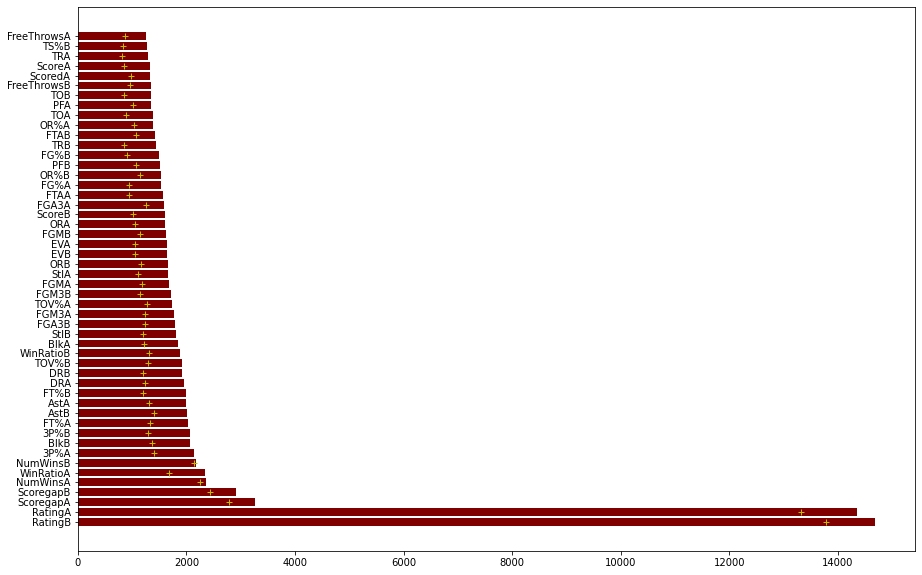

In [ ]:
top = 50
fig = plt.figure(figsize = (15, 10))
# creating the bar plot
plt.barh(Best_valid.index[:top], Best_valid[:top], color ='maroon',)
plt.plot(Mean_valid[:top], Mean_valid.index[:top], 'y+')

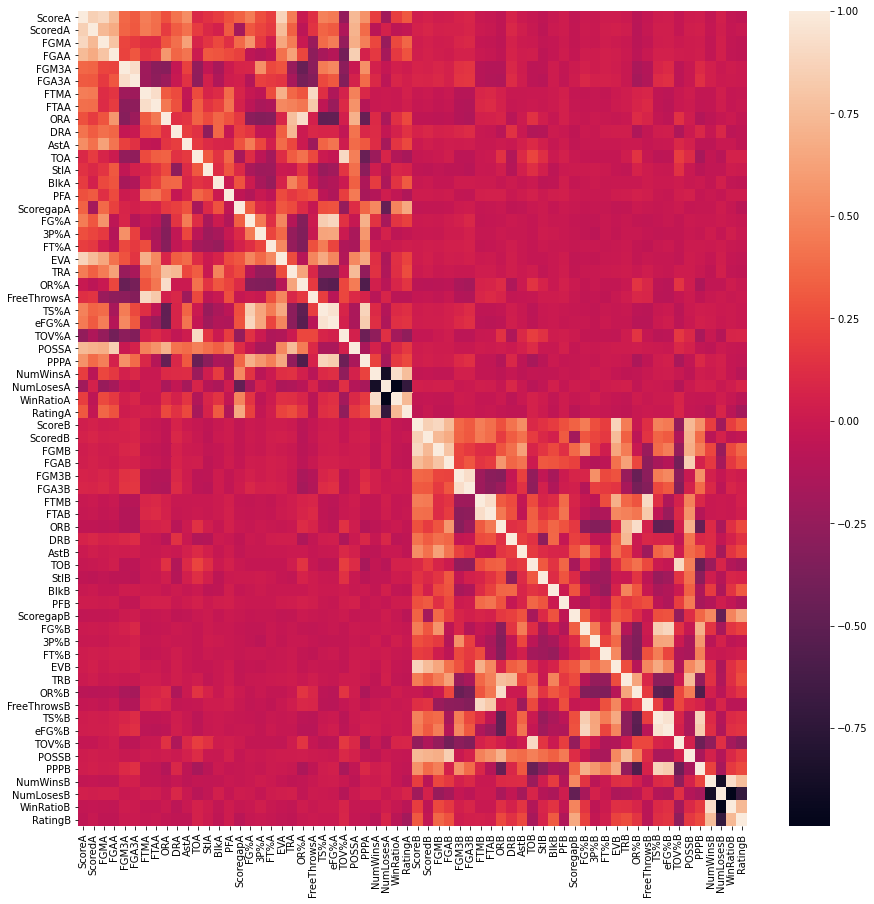

In [ ]:
import seaborn as sns
plt.figure(figsize = (15,15))
corr = tourney_results[features].corr()
ax = sns.heatmap(corr) 

**Nhận xét**: Trong số các feature được sử dụng, Rating của 2 đội cho thấy là một yếu tố cốt lõi dẫn đến kết quả dự đoán.

### V. Submission

Do kết quả mùa giải 2021 đã kết thúc nên nhóm đã thu thập dữ liệu này để tiện trình bày kết quả. Ở đây sẽ không có dữ liệu của mùa giải 2020 do ảnh hưởng của dịch Covid-19 nên mùa giải này đã bị hủy.

**Note**: Dữ liệu này tất nhiên chỉ dùng khi trình bày và so sánh cuối cùng, không được sử dụng trong đánh giá mô hình ^^

In [ ]:
test

,ID,Pred,Season,TeamIdA,TeamIdB,ScoreA,ScoredA,FGMA,FGAA,FGM3A,...,FreeThrowsB,TS%B,eFG%B,TOV%B,POSSB,PPPB,NumWinsB,NumLosesB,WinRatioB,RatingB
0,2021_1101_1104,0.5,2021,1101,1104,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.202236,0.516253,0.480270,0.168501,85.805833,0.858527,24.0,6.0,0.800000,92.297375
1,2021_1101_1111,0.5,2021,1101,1111,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.233738,0.515352,0.472577,0.145042,76.587413,0.881209,13.0,11.0,0.541667,79.201104
2,2021_1101_1116,0.5,2021,1101,1116,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.221129,0.526317,0.486577,0.155470,87.953939,0.888981,22.0,6.0,0.785714,89.756430
3,2021_1101_1124,0.5,2021,1101,1124,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.152241,0.517712,0.496066,0.120352,83.467273,0.910809,22.0,2.0,0.916667,95.559039
4,2021_1101_1140,0.5,2021,1101,1140,71.348684,65.394737,25.921053,58.335526,7.486842,...,0.190797,0.560098,0.527989,0.163867,79.680702,0.936633,19.0,6.0,0.760000,87.895307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2273,2021_1452_1457,0.5,2021,1452,1457,77.305556,74.638889,26.388889,62.250000,7.444444,...,0.179135,0.466051,0.433579,0.120855,82.743478,0.819452,23.0,1.0,0.958333,83.170189
2274,2021_1452_1458,0.5,2021,1452,1458,77.305556,74.638889,26.388889,62.250000,7.444444,...,0.197951,0.526560,0.487662,0.116220,73.875000,0.930726,17.0,12.0,0.586207,86.688764
2275,2021_1455_1457,0.5,2021,1455,1457,68.071429,68.921429,22.964286,59.707143,7.671429,...,0.179135,0.466051,0.433579,0.120855,82.743478,0.819452,23.0,1.0,0.958333,83.170189
2276,2021_1455_1458,0.5,2021,1455,1458,68.071429,68.921429,22.964286,59.707143,7.671429,...,0.197951,0.526560,0.487662,0.116220,73.875000,0.930726,17.0,12.0,0.586207,86.688764


In [ ]:
result = pd.read_csv("./2021NCAA.csv")
test["Predict"] = np.mean(y_test,axis=0)
pred = test[["TeamIdA","TeamIdB","Predict"]]

In [ ]:
total = result.merge(pred,left_on=["TeamIdA","TeamIdB"],right_on=["TeamIdA","TeamIdB"])
total

,TeamIdA,TeamIdB,Result,Predict
0,1111,1313,0,0.663680
1,1179,1455,1,0.620937
2,1277,1417,0,0.285340
3,1140,1417,0,0.513253
4,1101,1417,0,0.332231
...,...,...,...,...
62,1160,1199,0,0.518002
63,1101,1400,1,0.232686
64,1163,1268,0,0.463359
65,1104,1233,1,0.863912


In [ ]:
score = log_loss(total["Result"],total["Predict"])
score

0.5657231068660264

**Nhận xét**: Dù kết quả đã được cải thiện qua những chỉnh sửa trên mô hình, tuy nhiên bằng một cách nào đó kết quả vẫn không bằng được với tác giả, khá là ảo diệu (￣へ￣)

### VI. Look back the process

**Khó khăn của mỗi thành viên**:

- 18120374: Không thích bóng rổ nên không có nhiều kiến thức.
- 1712401: Khó khăn trong việc cải thiện độ chính xác.
- 1712575: Mất quá nhiều thời gian để hiểu hết các thuộc tính của các tập dữ liệu vì bài toán liên quan đến chuyên ngành bóng rổ quá
- 18120249: Ngoài những đặc trưng khá lạ lẫm trong một bài toán về lĩnh vực ít tiếp xúc, trước khi bắt đầu thì cá nhân em chưa thực sự giải quyết 1 bài toán học máy nhiều nên chưa nắm được đâu là những điểm còn thiếu sót trong mô hình hiện có. Ngoài ra light GBM cung cấp khá nhiều công cụ giúp tối ưu mô hình nên những thiếu hụt kiến thức vô hình chung đã làm giảm sức mạnh của mô hình :v

**Những điều đã học được**:

- Cách tiền xử lý dữ liệu bảng.
- Chuẩn bị dữ liệu để đưa vào mô hình huấn luyện.
- Học được thuật toán LightGBM, phương pháp đạt giải rất nhiều cuộc thi trên Kaggle.
- Tiến một bước vào cờ bạc.
- Có thêm nhiều kiến thức trong DA
- Nhờ vào việc light GBM có nhiều tham số cũng như có tích hợp nhiều kĩ thuật hỗ trợ phụ như bagging, feature_fraction,.. bên cạnh những điểm nổi bật như GOSS hay leaf-wise,... nên khi tìm hiểu về light GBM, em cũng hiểu thêm về những kĩ thuật này. Ngoài ra, khi nói về ưu điểm của một mô hình, người ta sẽ so sánh chúng với các mô hình khác, nhờ đó em cũng nắm được thêm một số kiến thức về một số mô hình khác như adaboost hay xgboost,...

**Kế hoạch của nhóm nếu có thêm thời gian**:

- Tìm hiểu xem trong tập data còn gì hữu ích (VD: Huấn luyện viên, trình độ,...)
- Thử thêm một vài model khác và so sánh với kq của tác giả.
- Mô hình hiện tại chỉ sử dụng light GBM, nếu có thêm thời gian nhóm có thể nghiên cứu những mô hình kết hợp khác (chẳng hạn của các tác giả xếp hạng 1~3, họ đều sử dụng những mô hình phức tạp hơn cũng như viết bằng những ngôn ngữ khác như R).

### VII. References
- Link Github của tác giả kazukim: [link](https://github.com/kazukim10)
- Một số nguồn mô tả về Light GBM và các tham số:
    - [Light GBM Document](https://lightgbm.readthedocs.io/en/latest/)
    - https://sites.google.com/view/lauraepp/parameters
    - https://neptune.ai/blog/lightgbm-parameters-guide
- Một số tài liệu khác về light GBM và Gradient Boosting
    - https://sefiks.com/2020/05/13/xgboost-vs-lightgbm/
    - https://ichi.pro/vi/lightgbm-la-gi-lam-the-nao-de-trien-khai-no-lam-the-nao-de-tinh-chinh-cac-thong-so-105778469517308
    - https://towardsdatascience.com/what-makes-lightgbm-lightning-fast-a27cf0d9785e
    - https://medium.com/riskified-technology/xgboost-lightgbm-or-catboost-which-boosting-algorithm-should-i-use-e7fda7bb36bc
    - https://viblo.asia/p/gradient-boosting-tat-tan-tat-ve-thuat-toan-manh-me-nhat-trong-machine-learning-YWOZrN7vZQ0
- Về bóng rổ và giải đấu bóng rổ NCAA:
    - [NCAA 2021 wikipedia](https://en.wikipedia.org/wiki/2021_NCAA_Division_I_Men%27s_Basketball_Tournament)
    - [BasketBall Statistic on Wikipedia](https://en.wikipedia.org/wiki/Basketball_statistics)
    - https://www.breakthroughbasketball.com/stats/definitions.html
    - [Image about Basketball](https://www.rookieroad.com/basketball/stats/rebounds/)
    - [Skill Explanation](https://jr.nba.com/field-goal-percentage-fg/)
    - [Statistic Formula in Basketball](https://www.nbastuffer.com/analytics101/)